Initialise  
Mid price - classification rather than, 
Label - neural network (Random Forest)
mid-price

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import glob
import re
from datetime import datetime

Import data

In [2]:
# Path pattern to match all CSV files
path_pattern = r'C:\Users\Tim\Documents\Bristol Uni\dsmp-2024-group18\ARIMA Model Development\Month Prediction\Month Data\January\*.csv'
all_files = glob.glob(path_pattern)

# List to hold all dataframes
li = []

for filename in all_files:
    # Extract date from filename using regex
    date_match = re.search(r'(\d{4}-\d{2}-\d{2})', filename)
    if date_match:
        file_date = datetime.strptime(date_match.group(), '%Y-%m-%d').date()
    
    df = pd.read_csv(filename, index_col=None, header=0)
    
    # Combine the extracted date with each 'Time' entry, assuming 'Time' is just time
    df['Time'] = pd.to_datetime(df['Time'].astype(str)).apply(lambda x: datetime.combine(file_date, x.time()))
    
    li.append(df)

# Concatenate all data into a single DataFrame
data = pd.concat(li, axis=0, ignore_index=True)

# Ensure 'Time' includes full datetime information and set it as the index
data.set_index('Time', inplace=True)

# Select only the numeric columns for resampling
numeric_data = data.select_dtypes(include=[np.number])

# Resample the numeric data to every minute, calculating the mean
data = numeric_data.resample('1T').mean()

data = data.dropna(subset=['Mid-Price'])

print(data.head())


C:\Users\Tim\AppData\Local\Temp\ipykernel_12836\535320902.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'].astype(str)).apply(lambda x: datetime.combine(file_date, x.time()))
C:\Users\Tim\AppData\Local\Temp\ipykernel_12836\535320902.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'].astype(str)).apply(lambda x: datetime.combine(file_date, x.time()))
C:\Users\Tim\AppData\Local\Temp\ipykernel_12836\535320902.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['T

                      Mid-Price  Total_volume  Bid_ask_spread  Order_imbalance
Time                                                                          
2025-01-02 07:30:00  263.588667    178.266667       20.544833         0.057500
2025-01-02 07:31:00  260.393500    157.416667        4.887333         0.122167
2025-01-02 07:32:00  265.426667    160.966667        4.646667         0.162667
2025-01-02 07:33:00  265.109333    150.300000        4.184167         0.041167
2025-01-02 07:34:00  265.925167    202.983333        5.501167         0.143500


Get a df with just time and mid-price

In [3]:
bid_ask_df = pd.DataFrame()
bid_ask_df['Bid_ask_spread'] = data['Bid_ask_spread']
bid_ask_df.set_index(data.index, inplace=True)
bid_ask_df.reset_index(drop=True, inplace=True)

print(type(bid_ask_df))
print(bid_ask_df.to_string(index=True, header=True))


<class 'pandas.core.frame.DataFrame'>
       Bid_ask_spread
0           20.544833
1            4.887333
2            4.646667
3            4.184167
4            5.501167
5            4.686000
6            9.980167
7            4.943167
8            6.360500
9            5.022167
10           5.246333
11           4.824500
12           6.953000
13           6.968833
14           5.906167
15          38.621667
16          48.188667
17          78.411333
18          27.412500
19          28.097000
20          22.890167
21          27.195000
22          15.548667
23          79.932333
24          35.819667
25          49.909000
26          21.443000
27           6.939500
28           5.939167
29          33.362333
30           8.850667
31           7.967167
32           6.160833
33           5.450667
34           6.608500
35          58.097833
36          53.541833
37          91.618833
38          90.596000
39          59.185167
40          48.248333
41          25.074833
42          26.5

Split the data 80:20 by time

       Bid_ask_spread
11215       42.781000
11216       55.028500
11217       38.662833
11218       60.372667
11219       47.724000


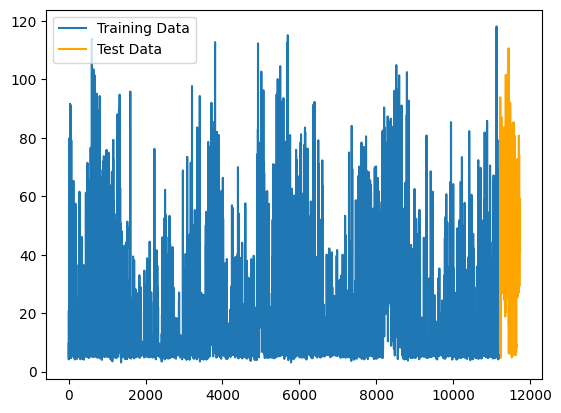

In [4]:
# Get just the mid price
day_length = 510 # 510 points per day

split_index = int(len(data) - day_length)


# Split the DataFrame into train and test sets based on the split index
train = (bid_ask_df[0:split_index])
test = (bid_ask_df[split_index:])

print(train.tail())

plt.plot(train, label = 'Training Data')
plt.plot(test, color = 'orange', label = 'Test Data')
plt.legend()
plt.show()


Do ADF Test to check if data is stationary 

In [5]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(mid_price):
    result=adfuller(mid_price)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [6]:
adfuller_test(train['Bid_ask_spread'])

ADF Test Statistic : -7.423256555869652
p-value : 6.650316371578823e-11
#Lags Used : 40
Number of Observations Used : 11179
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Plot ACF

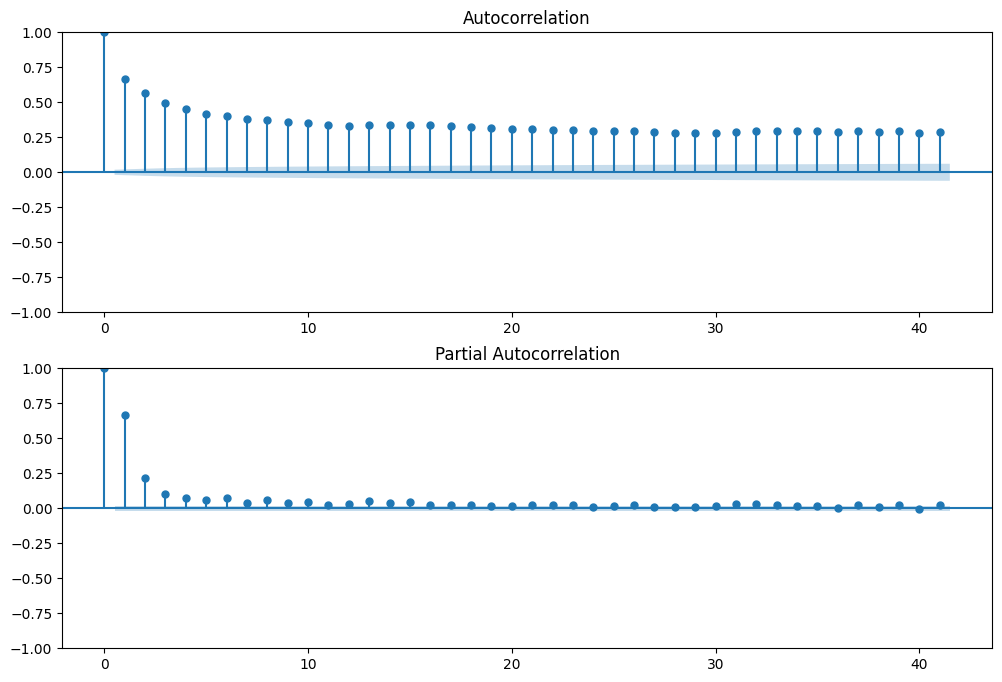

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train, ax=ax[0])  # ACF plot for 'Mid-Price'
plot_pacf(train, ax=ax[1])  # PACF plot for 'Mid-Price'

plt.show()

Use pdarima package to check d calc

In [8]:
from pmdarima.arima.utils import ndiffs 
ndiffs(train, test = "adf")

0

Plot interpretation

ACF Plot Interpretation:

The ACF plot tails off gradually, which indicates that the data may be either an AR process or a mixed ARMA process. In an ACF plot for a pure MA process, we would expect a sharp cut-off after the significant lags. Therefore p = 1.

PACF Plot Interpretation:

The PACF plot shows a significant spike at lag 1, and then it almost immediately cuts off (becomes insignificant). Given the lack of significant spikes in the ACF plot beyond the immediate lag, I will start with q=0 and test q=1 as well.

Differencing Term (d):

As per the ADF test, the data is stationary so d = 0




Do ARIMA Test

In [9]:
print(train)

       Bid_ask_spread
0           20.544833
1            4.887333
2            4.646667
3            4.184167
4            5.501167
...               ...
11215       42.781000
11216       55.028500
11217       38.662833
11218       60.372667
11219       47.724000

[11220 rows x 1 columns]


In [10]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# Use auto_arima to find the best ARIMA parameters
auto_model = auto_arima(train, seasonal=False, trace=True)
# Print the summary of the best model
print(auto_model.summary())
# Extract the best order
best_order = auto_model.order
print("Best ARIMA order:", best_order)

# Now you can use the best order to fit your ARIMA model
model = ARIMA(train, order=best_order)
model_fit = model.fit()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=89036.231, Time=6.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=92157.746, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=90703.553, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=89907.496, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=92155.746, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=89034.563, Time=3.80 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=89550.198, Time=1.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=89209.840, Time=2.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=89036.274, Time=5.65 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=89301.553, Time=3.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=89050.044, Time=3.02 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=89037.507, Time=8.66 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=89032.570, Time=1.67 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=89548.208, Time=0.58 sec
 ARIMA(1,1,1)(0,0,0

In [12]:
horizon = 1  # Predicting one step ahead

predictions = []
actuals = []

# Start the rolling forecasting
for end in range(split_index, len(bid_ask_df) - horizon + 1):
    
    # Extract current training data
    train = bid_ask_df['Bid_ask_spread'].iloc[:end]
    
    # Fit the ARIMA model with the chosen order
    model = ARIMA(train, order=best_order)  # Ensure you've chosen the best order
    model_fit = model.fit()
    
    # Forecast the next point
    forecast = model_fit.forecast(steps=horizon)
    predictions.append(forecast.iloc[0])  # Appending the forecasted value
    
    # Appending the actual value for comparison
    actuals.append(bid_ask_df['Bid_ask_spread'].iloc[end + horizon - 1])


In [13]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(actuals, predictions)
print('Test Mean Squared Error:', error)

print(predictions)
print(actuals)

Test Mean Squared Error: 300.7631687958734
[41.22451024324176, 25.261401481802256, 17.163983690003704, 14.875249238956421, 14.500656316292849, 14.433979940725902, 14.285896189595297, 53.36137291949699, 45.59691155902961, 33.6836482611924, 43.51833911693037, 42.74089288281361, 42.89305662122875, 52.56388826091874, 39.471681941143395, 48.659903442921376, 52.71013493755495, 53.85507605125153, 37.26294657266069, 48.52230693319944, 55.95165574981526, 50.254128095891026, 26.718984993833175, 19.050710236273087, 17.45829495959491, 16.003073876704438, 17.12054935565416, 16.09931333228184, 26.781994314667646, 37.35438900949259, 42.72575978558935, 57.97540513294909, 44.04480666325748, 42.86495324117079, 44.267111710579435, 40.33928725535304, 42.24000159730215, 49.638856717592056, 63.13206709820945, 47.391246094964686, 38.73197550649315, 57.665807904354224, 47.15577673775053, 43.13616633168688, 59.62558878235738, 39.42592778361646, 37.07499681099448, 51.57904459940266, 46.688115145468096, 55.42558

Plot

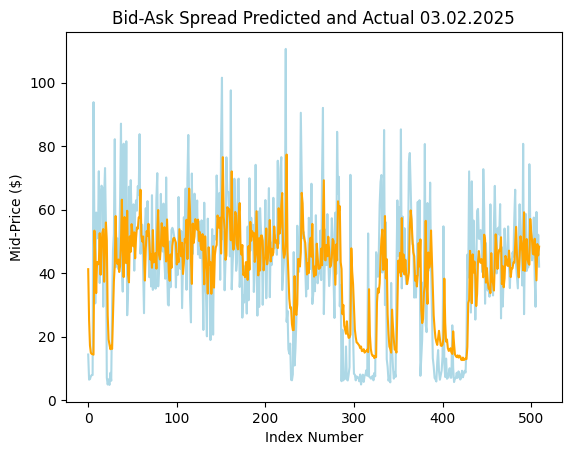

In [15]:
plt.plot(actuals, color = 'lightblue', label = 'Actual')
plt.plot(predictions, color = 'orange', label = 'Predicted')
plt.title('Bid-Ask Spread Predicted and Actual 03.02.2025')
plt.xlabel('Index Number')
plt.ylabel('Mid-Price ($)')
plt.show()

In [32]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(actuals, predictions)
print('Test Mean Squared Error:', error)

print(predictions)
print(actuals)

Test Mean Squared Error: 138.43520980987222
[321.1500294473928, 309.13796191629206, 310.2239697466457, 307.80299626462886, 305.17354073507397, 302.80141970295733, 301.40271462923874, 321.7062221425285, 320.2240132108579, 317.5285702104372, 322.73708007090266, 324.36527623958006, 310.3303045259036, 326.04141218081486, 316.8596316606671, 315.51377024958646, 325.6102483976373, 324.1044598094164, 322.1719379633347, 327.14451745608045, 331.08742031741536, 321.17453795409284, 320.9039866915643, 319.5008727873826, 319.0603407985248, 318.38705492673137, 318.2370481223019, 313.3203476790227, 318.2564405257574, 324.27728609465146, 327.07807893267307, 334.353281477502, 326.7158394550599, 329.1754919667106, 329.502424028165, 329.85223172041333, 331.19040955345014, 329.1332036688681, 334.7529373021884, 328.3955303951486, 328.50439250422454, 334.4918744228216, 323.29988222079, 328.2709396708374, 333.8174203063724, 324.84531630905883, 326.4335559408425, 330.61878709264585, 326.5369945947104, 330.3095